# Hypothesis - Device Activity

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample

**Read Data**

In [3]:
# import data
data = pd.read_csv('../data/raw/raw_data.csv')
print(f"data shape: {data.shape}")
data.head()

data shape: (1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


## Data Cleaning + Undersampling

1. Followed 1.0-data-preprocessing.ipynb

In [4]:
# Data Cleaning
data['intended_balcon_amount'] = data['intended_balcon_amount'].apply(lambda x: -1 if x < 0 else x)
data = data[(data['current_address_months_count'] >= 0) & (data['session_length_in_minutes'] >= 0) & (data['device_distinct_emails_8w'] >= 0)]

# Convert the variables to the appropriate data types
data['fraud_bool'] = data['fraud_bool'].astype('category')
data['payment_type'] = data['payment_type'].astype('category')
data['employment_status'] = data['employment_status'].astype('category')
data['email_is_free'] = data['email_is_free'].astype('uint8')
data['housing_status'] = data['housing_status'].astype('category')
data['phone_home_valid'] = data['phone_home_valid'].astype('uint8')
data['phone_mobile_valid'] = data['phone_mobile_valid'].astype('uint8')
data['has_other_cards'] = data['has_other_cards'].astype('uint8')
data['foreign_request'] = data['foreign_request'].astype('uint8')
data['source'] = data['source'].astype('category')
data['device_os'] = data['device_os'].astype('category')

# Remove Redundant rows
data.drop(columns=['device_fraud_count'], inplace=True)

# Ratio of 1 to 5
# Separate fraud and non-fraud data
fraud_data = data[data['fraud_bool'] == 1]
non_fraud_data = data[data['fraud_bool'] == 0]

# Undersample non-fraud data to match the size of the fraud data
undersampled_non_fraud_data = resample(non_fraud_data, replace=False, n_samples=5*len(fraud_data), random_state=42)

# Combine fraud and undersampled non-fraud data
undersampled_data = pd.concat([fraud_data, undersampled_non_fraud_data])

data = undersampled_data

# check shape and head of data
print(f"data shape: {data.shape}")
data.head()

data shape: (65970, 31)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
43,1,0.9,0.570800,-1,157,60,0.005908,35.337538,AA,4079,...,30,0,1500.0,0,INTERNET,4.036394,windows,1,1,0
140,1,0.1,0.993219,-1,67,20,0.015331,92.120139,AA,1192,...,25,0,1500.0,0,INTERNET,12.928072,windows,0,1,0
284,1,0.8,0.794351,-1,376,60,17.925951,41.422110,AA,815,...,28,0,1500.0,0,INTERNET,2.550167,linux,0,1,0
314,1,0.7,0.090000,-1,58,50,0.004134,-1.000000,AD,4011,...,27,0,1500.0,0,INTERNET,3.500856,windows,0,1,0
561,1,0.9,0.998248,31,45,30,0.010165,33.067538,AA,525,...,1,1,2000.0,0,INTERNET,44.536211,windows,0,1,0


## EDA Bank Activity and Device Activity

**Hypothesis: Fraudulent Bank Accounts have unique characteristics in relation to how their device activity.**
* More likely to use a phone that has more lax security i.e. windows
* More likely to have more than 1 email in each device. --> more emails to create more fake accounts
* If a phone has more than 1 email from each device, then it keep_alive_session likely to be false (i.e. value=0) --> convienience on fraudster's end. troublesome to log in and out continually.
* Session length will also be short??

**Columns considered**

* Device Activity:
    * `session_length_in_minutes`
    * `device_os`
    * `keep_alive_session`
    * `device_distinct_emails_8w`
    * `source`
    * `foreign_request`

* Bank Activity:
    * `zip_count_4w`
    * `velocity_6h`
    * `velocity_24h`
    * `velocity_4w`
    * `bank_branch_count_8w`
    * `date_of_birth_distinct_emails_4w`

**Explanation of Columns**

| Column Name | Description | Link to Fraud |
|:------------|:------------|:--------------|
| device_distinct_emails_8w | No. of distinct emails in banking website from the used device in last 8 weeks. <br> Simply put, if I use my email address to log into the banking website, <br> then I effectively used 1 distinct email address. <br>If I leave the phone unattended for 8 weeks, then this value becomes 0 due to inactivity for 8 weeks. | Spare phones are commonly used to prevent banking companies from tracking them. <br> Thus, able to explain the inactivity. When the phone is actually used, <br>the fraudsters are likely to use more than 2 distinct email address for 2 accounts using the same phone.


In [5]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'source', 'foreign_request']
device_activity_df = data[device_activity]

# print shape
device_activity_df.shape
device_activity_df.head()

,fraud_bool,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,source,foreign_request
43,1,4.036394,windows,1,1,INTERNET,0
140,1,12.928072,windows,0,1,INTERNET,0
284,1,2.550167,linux,0,1,INTERNET,0
314,1,3.500856,windows,0,1,INTERNET,0
561,1,44.536211,windows,0,1,INTERNET,0


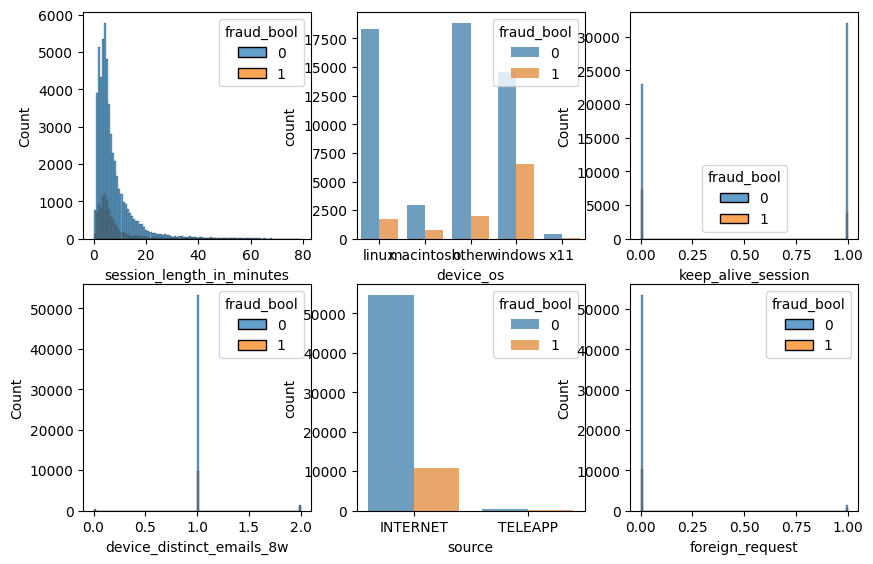

In [6]:
# for each column, if it is categorical, plot the value counts, if it is numerical, plot histogram
# put in a 3 x 3 grid, and color code the fraud_bool column
# print all except the first column
plt.figure(figsize=(10, 10))
for i, col in enumerate(device_activity_df.columns[1:]):
    plt.subplot(3, 3, i+1)
    if device_activity_df[col].dtype.name == 'category':
        sns.countplot(data=device_activity_df, x=col, hue='fraud_bool', alpha=0.7)
    else:
        sns.histplot(data=device_activity_df, x=col, hue='fraud_bool', bins=100, alpha=0.7)

/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_42623/1158177696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_activity_df['device_distinct_emails_8w'] = device_activity_df['device_distinct_emails_8w'].astype('category')


                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258


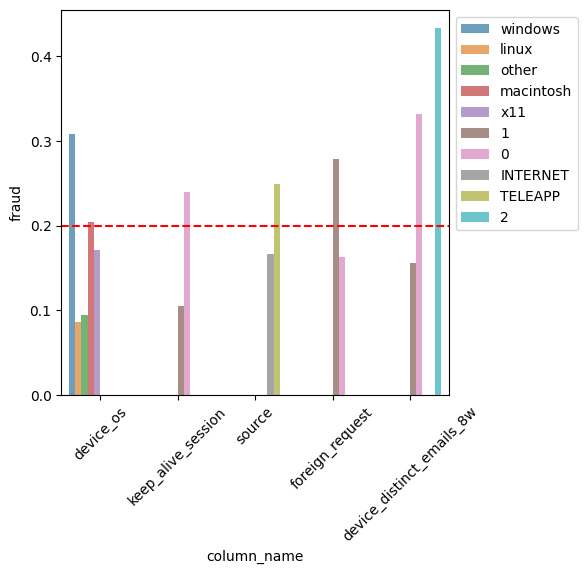

In [7]:
# chance device_distinct_emails_8w to category
device_activity_df['device_distinct_emails_8w'] = device_activity_df['device_distinct_emails_8w'].astype('category')

# check proportion of fraud vs non-fraud within each category
categorical_columns = ['fraud_bool', 'device_os', 'keep_alive_session', 'source', 'foreign_request', 'device_distinct_emails_8w']
device_activity_df_cat = device_activity_df[categorical_columns]

# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 1: `device_distinct_emails` == 0 or 2 & `device_os` == windows --> featureEng01 == 1, else 0

<Axes: xlabel='featureEng01', ylabel='count'>

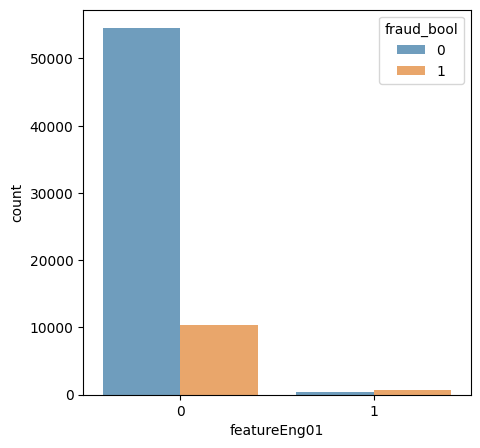

In [7]:
# label columns with the following conditions met as a new column, 'featureEng01'
# if conditions met, label as 1, else 0
# 1. device_os is 'windows'
# 2. device_distinct_emails_8w is 0 or 2
device_activity_df_cat['featureEng01'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_os'] == 'windows') & (device_activity_df_cat['device_distinct_emails_8w'].isin([0, 2])), 'featureEng01'] = 1

# change 'featureEng01' to category
device_activity_df_cat['featureEng01'] = device_activity_df_cat['featureEng01'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng01', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

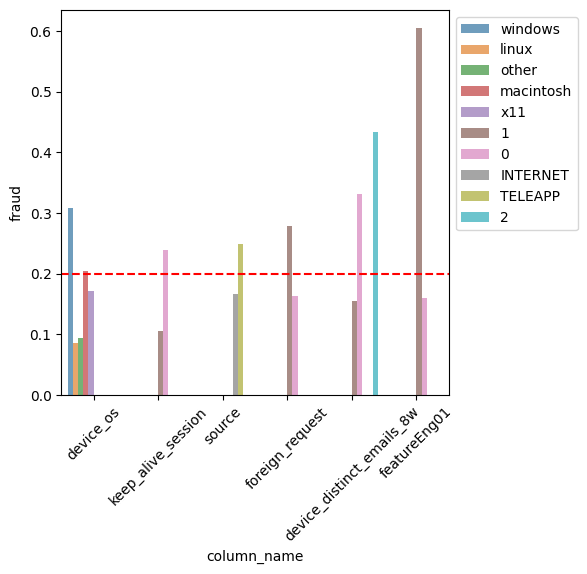

In [8]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 2: `device_distinct_emails_8w` == 2 & `keep_alive_session` == 0, featureEng02 == 1, else 0

<Axes: xlabel='featureEng02', ylabel='count'>

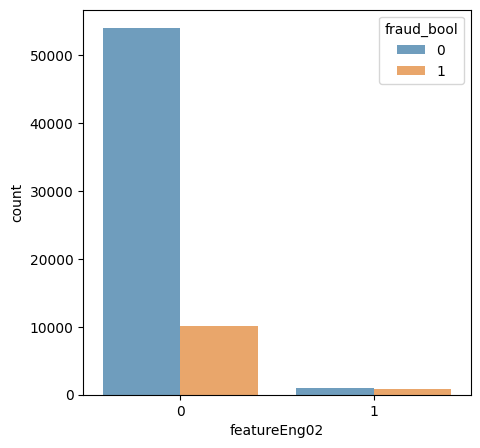

In [9]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng02'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_distinct_emails_8w'] == 2) & (device_activity_df_cat['keep_alive_session'] == 0), 'featureEng02'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng02'] = device_activity_df_cat['featureEng02'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng02', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

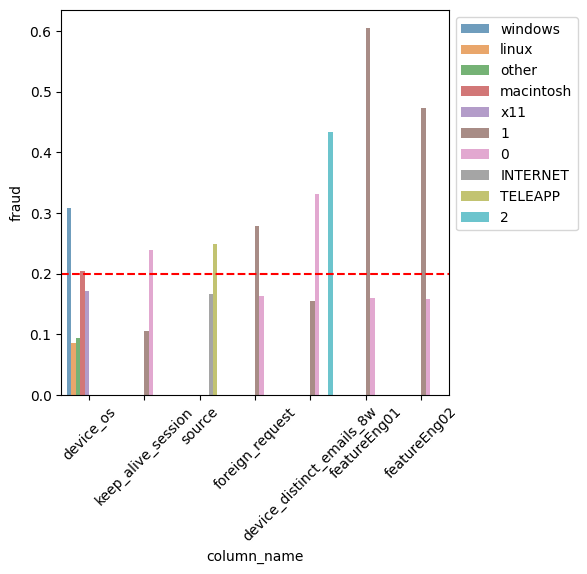

In [10]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 3: `device_distinct_emails_8w` == 0/2 & `keep_alive_session` == 0 --> featureEng03 == 1, else 0

<Axes: xlabel='featureEng03', ylabel='count'>

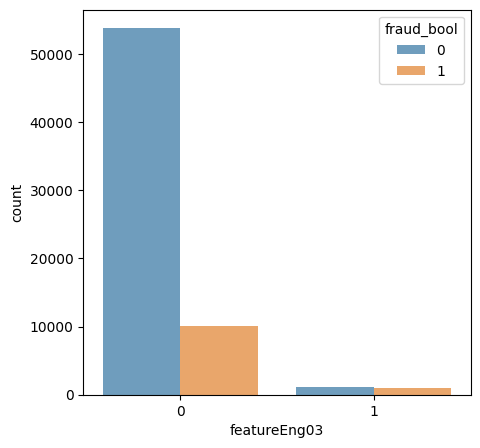

In [11]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng03'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_distinct_emails_8w'].isin([0, 2])) & (device_activity_df_cat['keep_alive_session'] == 0), 'featureEng03'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng03'] = device_activity_df_cat['featureEng03'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng03', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

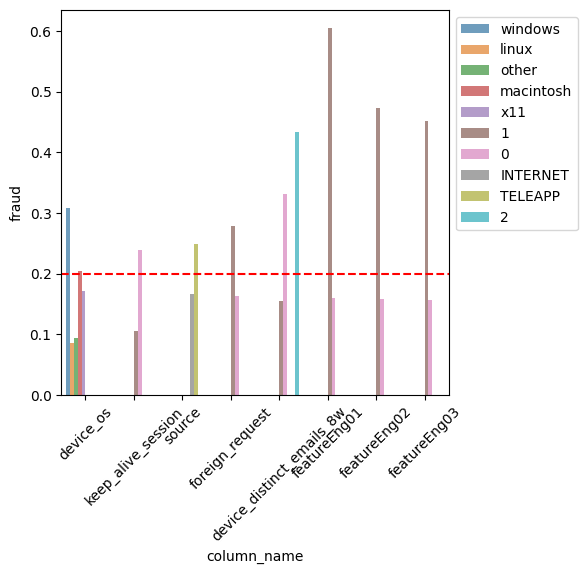

In [12]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 4: `foreign_request` == 1 & `source` == TELEAPP, then featureEng04 = 1, else 0

In [13]:
print(device_activity_df_cat[['featureEng01']].value_counts())
print(device_activity_df_cat[['featureEng02']].value_counts())
print(device_activity_df_cat[['featureEng03']].value_counts())

featureEng01
0               64829
1                1141
Name: count, dtype: int64
featureEng02
0               64176
1                1794
Name: count, dtype: int64
featureEng03
0               63801
1                2169
Name: count, dtype: int64


<Axes: xlabel='featureEng04', ylabel='count'>

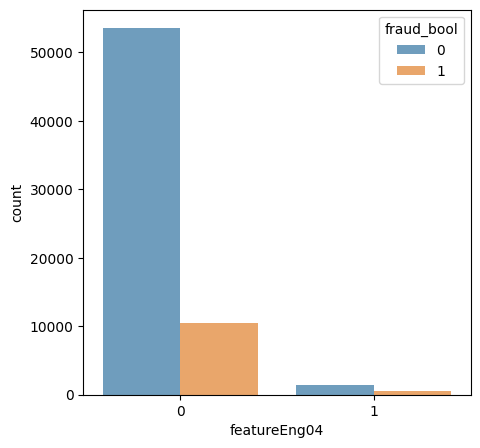

In [15]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng04'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['foreign_request'] == 1) & (device_activity_df_cat['source'] == 'INTERNET'), 'featureEng04'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng04'] = device_activity_df_cat['featureEng04'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng04', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

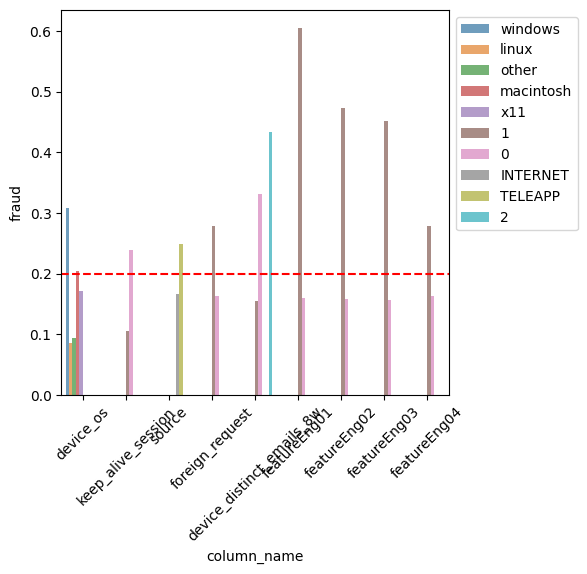

In [16]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Feature 5: `source` == INTERNET & `device_os` == windows, featureEng05 = 1, else 0

<Axes: xlabel='featureEng05', ylabel='count'>

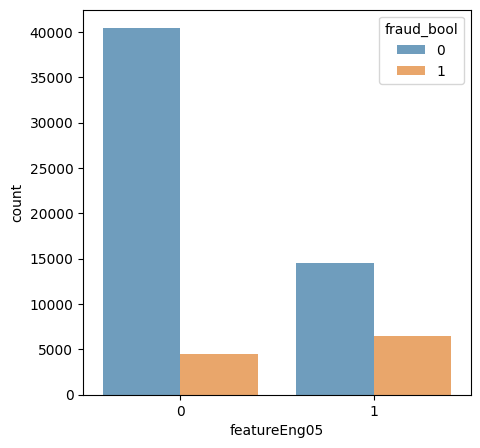

In [17]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng05'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['source'] == 'INTERNET') & (device_activity_df_cat['device_os'] == 'windows'), 'featureEng05'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng05'] = device_activity_df_cat['featureEng05'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng05', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os  macintosh  0.204076   0.795924
0                  device_os        x11  0.171247   0.828753
0         keep_alive_session          1  0.105193   0.894807
0         keep_alive_session          0  0.239448   0.760552
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

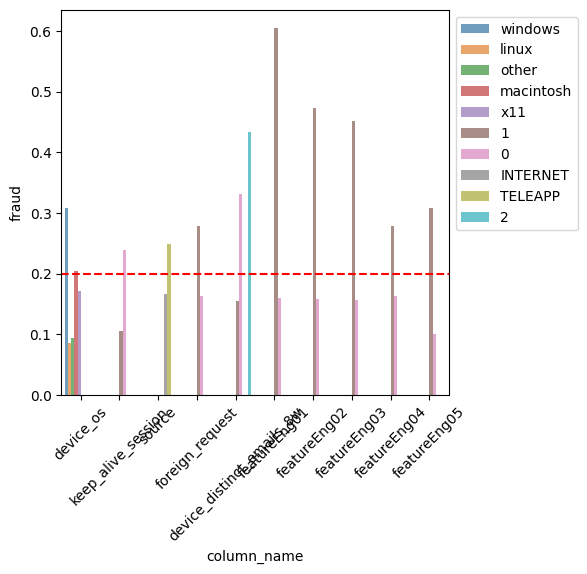

In [18]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Summary of Feature Engineering

In [ ]:
# feature01: device_os is 'windows' and device_distinct_emails_8w is 0 or 2
# feature02: device_distinct_emails_8w is 2 or keep_alive_session is '0'
# feature03: device_distinct_emails_8w is 0 or 2 or keep_alive_session is '0'
# feature04: foreign_request is 1 and source is 'INTERNET'
# feature05: source is 'INTERNET' and device_os is 'windows'

In [8]:
device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]

10995

In [9]:
total_fraud_count = device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]
total_non_fraud_count = device_activity_df['fraud_bool'].value_counts().to_frame().loc[1, "count"]

# print total counts of fraud and non-fraud
print(f"Total Fraud Count: {total_fraud_count}")
print(f"Total Non-Fraud Count: {total_non_fraud_count}")
print(f"Total Count: {total_fraud_count + total_non_fraud_count} \t Data Shape: {device_activity_df.shape}")

Total Fraud Count: 10995
Total Non-Fraud Count: 10995
Total Count: 21990 	 Data Shape: (65970, 7)


In [10]:
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (65970, 7)


,fraud_bool,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,source,foreign_request
43,1,4.036394,windows,1,1,INTERNET,0
140,1,12.928072,windows,0,1,INTERNET,0
284,1,2.550167,linux,0,1,INTERNET,0
314,1,3.500856,windows,0,1,INTERNET,0
561,1,44.536211,windows,0,1,INTERNET,0


In [11]:
device_activity_df.dtypes

fraud_bool                   category
session_length_in_minutes     float64
device_os                    category
keep_alive_session              int64
device_distinct_emails_8w    category
source                       category
foreign_request                 uint8
dtype: object

In [12]:
def getFraudInfo(group):
    # get total count of fraud within this group
    fraud_count = group['fraud_bool'].value_counts().to_frame().loc[1, "count"]
    total_count = group.shape[0]
    fraud_percentage = round(fraud_count / total_count * 100, 2)

    group['num_fraud'] = fraud_count
    group['proportion_of_fraud_in_group'] = fraud_percentage
    return group[['num_fraud', 'proportion_of_fraud_in_group']].drop_duplicates()

In [13]:
# feature01: device_os is 'windows' and device_distinct_emails_8w is 0 or 2
device_activity_df.groupby(['device_os', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index()

,device_os,device_distinct_emails_8w,level_2,num_fraud,proportion_of_fraud_in_group
0,linux,0,87839,9,13.85
1,linux,1,284,1546,8.02
2,linux,2,7307,156,24.92
3,macintosh,0,83650,12,48.00
4,macintosh,1,3150,674,19.20
5,macintosh,2,2065,65,44.83
6,other,0,15214,63,27.75
7,other,1,1139,1726,8.63
8,other,2,4511,169,30.62
9,windows,0,5351,53,54.08


(0.0, 6000.0)

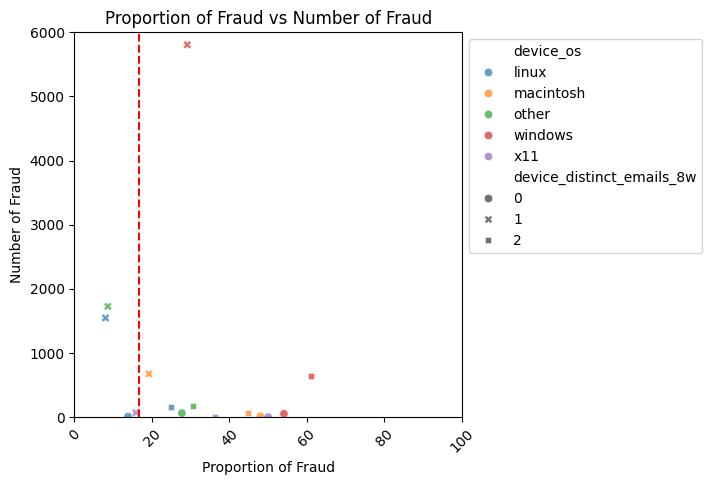

In [14]:
# plot a scatter plot, x-axis: proportion of fraud, y-axis: number of fraud
# plot a vertical line at x = 1/6, make title, x-axis label, y-axis label, and legend, x-axis tilt by 45 degrees
# color code by device_os and device_distinct_emails_8w, for example, device_os = 'windows' and device_distinct_emails_8w = 0 is red, etc..
# axes must start from 0
plt.figure(figsize=(5, 5))
sns.scatterplot(data=device_activity_df.groupby(['device_os', 'device_distinct_emails_8w']).apply(getFraudInfo).reset_index(), x='proportion_of_fraud_in_group', y='num_fraud', hue='device_os', style='device_distinct_emails_8w', alpha=0.7)
plt.axvline(x=100/6, color='r', linestyle='--')
plt.title('Proportion of Fraud vs Number of Fraud')
plt.xlabel('Proportion of Fraud')
plt.ylabel('Number of Fraud')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0, 100)
plt.ylim(0, 6000)


In [ ]:
# 5 groups
# group01 = filter for conditions where device_os == windows and device_distinct_emails_8w.isin([0,2])
# group02 = filter for conditions where device_os == macintosh and device_distinct_emails_8w.isin([0,2])
# group03 = filter for conditions where device_os == x11 and device_distinct_emails_8w.isin([0,2])
# group04 = filter for conditions where device_os == other and device_distinct_emails_8w.isin([0,2])
# group05 = everything else



In [15]:
device_activity_df.groupby(['device_os']).apply(getFraudInfo).reset_index()

,device_os,level_1,num_fraud,proportion_of_fraud_in_group
0,linux,284,1711,8.57
1,macintosh,2065,751,20.41
2,other,1139,1958,9.42
3,windows,43,6494,30.83
4,x11,10801,81,17.12


In [ ]:
print(f'device_activity_df_cat shape: {device_activity_df_cat.shape}')
device_activity_df_cat.head()

In [ ]:
# find unique combinations of device_os and device_distinct_emails_8w columns
unique_dev_os_dev_distinct_emails_8w = device_activity_df_cat[['device_os', 'device_distinct_emails_8w']].drop_duplicates().reset_index(drop=True)

print(f'unique_dev_os_dev_distinct_emails_8w shape: {unique_dev_os_dev_distinct_emails_8w.shape}')
unique_dev_os_dev_distinct_emails_8w.head()

In [ ]:
# group device_activity_df_cat by device_os and device_distinct_emails_8w columns
# for each group, calculate 4 values, 
device_activity_df_cat_grouped = device_activity_df_cat.groupby(['device_os', 'device_distinct_emails_8w'])

**Hypothesis: Fraudulent Bank Accounts have unique characteristics in relation to how their device activity.**

* More likely to use a phone that has more lax security i.e. windows
* More likely to have more than 1 email in each device. --> more emails to create more fake accounts
* If a phone has more than 1 email from each device, then it keep_alive_session likely to be false (i.e. value=0) --> convienience on fraudster's end. troublesome to log in and out continually.
* Session length will also be short??


**Insights**

1. 

In [ ]:
# split session_length_in_minutes into 2 groups, fraud and non-fraud
session_length_fraud = device_activity_df[device_activity_df['fraud_bool'] == 1][['session_length_in_minutes', 'fraud_bool']]
sessions_length_non_fraud = device_activity_df[device_activity_df['fraud_bool'] == 0][['session_length_in_minutes', 'fraud_bool']]

# print shapes
print(f"fraud shape: {session_length_fraud.shape}")
print(f"non-fraud shape: {sessions_length_non_fraud.shape}")

In [ ]:
# plot boxplot for non-fraud session length in minutes
# plot side by side, with different colors, on columns 'session_length_in_minutes'
plt.figure(figsize=(6, 3))
sns.boxplot(data=session_length_fraud, x='session_length_in_minutes', color='red')

In [ ]:
# plot boxplot for non-fraud session length in minutes
plt.figure(figsize=(6, 3))
sns.boxplot(data=sessions_length_non_fraud, x='session_length_in_minutes', color='blue')

In [ ]:
device_activity_df.columns

In [ ]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'source', 'foreign_request']
device_activity_df = data[device_activity]

In [ ]:
# check value_counts for device_distinct_emails_8w
device_activity_df['device_distinct_emails_8w'].value_counts()

In [ ]:
# select device_distinct_emails_8w and fraud_bool columns, and select all the frauds
device_distinct_emails_fraud = device_activity_df[device_activity_df['fraud_bool'] == 1][['device_distinct_emails_8w', 'fraud_bool']]
device_distinct_emails_non_fraud = device_activity_df[device_activity_df['fraud_bool'] == 0][['device_distinct_emails_8w', 'fraud_bool']]

# plot count plot for both fraud and non-fraud, in 1 x 2 grid, provide title for each
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=device_distinct_emails_fraud, x='device_distinct_emails_8w', hue='fraud_bool')
plt.title('Fraud')
plt.subplot(1, 2, 2)
sns.countplot(data=device_distinct_emails_non_fraud, x='device_distinct_emails_8w', hue='fraud_bool')
plt.title('Non-Fraud')


In [ ]:
# use the device_activity_df, combine the device_os and keep_alive_sessions columns
# change device_os and keep_alive_session to str
device_activity_df['device_os'] = device_activity_df['device_os'].astype(str)
device_activity_df['keep_alive_session'] = device_activity_df['keep_alive_session'].astype(str)
device_activity_df['device_os_keep_alive'] = device_activity_df['device_os'] + '_' + device_activity_df['keep_alive_session']

# plot countplot for device_os_keep_alive
plt.figure(figsize=(12, 6))
sns.countplot(data=device_activity_df, x='device_os_keep_alive', hue='fraud_bool')

In [ ]:
# convert device_activity_df['fraud_bool'] to 1 and 0
device_activity_df['fraud_bool'] = device_activity_df['fraud_bool'].astype(int)

# group by device_os_keep_alive
# within each group, find the 2 proportions - proportion of frauds, i.e. number of fraud/total, and proportion of non-frauds, i.e. number of non-frauds/total
device_os_keep_alive_grouped = device_activity_df.groupby('device_os_keep_alive')

# iterate through each group, create a dataframe where the row corresponds to the group, and the columns are 'fraud_proportion' and 'non_fraud_proportion'
fraud_proportion = []
non_fraud_proportion = []
for name, group in device_os_keep_alive_grouped:
    fraud_proportion.append(group['fraud_bool'].sum()/len(group))
    non_fraud_proportion.append((len(group) - group['fraud_bool'].sum())/len(group))

# create a dataframe
fraud_non_fraud_proportion_df = pd.DataFrame({'device_os_keep_alive': device_os_keep_alive_grouped.groups.keys(), 'fraud_proportion': fraud_proportion, 'non_fraud_proportion': non_fraud_proportion})
fraud_non_fraud_proportion_df.head()

# plot in such that it is a barplot, but the bars are stacked
plt.figure(figsize=(12, 6))
plt.bar(fraud_non_fraud_proportion_df['device_os_keep_alive'], fraud_non_fraud_proportion_df['non_fraud_proportion'], bottom=fraud_non_fraud_proportion_df['fraud_proportion'], label='non-fraud')
plt.bar(fraud_non_fraud_proportion_df['device_os_keep_alive'], fraud_non_fraud_proportion_df['fraud_proportion'], label='fraud')
plt.legend()


In [ ]:
device_activity_df.head()

In [ ]:
device_activity_df.dtypes

In [ ]:
# values count for distinct_emails_8w
device_activity_df['device_distinct_emails_8w'].value_counts()

# group by device_distinct_emails_8w
# within each group, find the 2 proportions - proportion of frauds, i.e. number of fraud/total, and proportion of non-frauds, i.e. number of non-frauds/total
device_distinct_emails_grouped = device_activity_df.groupby('device_distinct_emails_8w')

# iterate through each group, create a dataframe where the row corresponds to the group, and the columns are 'fraud_proportion' and 'non_fraud_proportion'
fraud_proportion = []
non_fraud_proportion = []
for name, group in device_distinct_emails_grouped:
    fraud_proportion.append(group['fraud_bool'].sum()/len(group))
    non_fraud_proportion.append((len(group) - group['fraud_bool'].sum())/len(group))

# create a dataframe
fraud_non_fraud_proportion_df = pd.DataFrame({'device_distinct_emails_8w': device_distinct_emails_grouped.groups.keys(), 'fraud_proportion': fraud_proportion, 'non_fraud_proportion': non_fraud_proportion})
fraud_non_fraud_proportion_df.head()

# plot in such that it is a barplot, but the bars are stacked
plt.figure(figsize=(12, 6))
plt.bar(fraud_non_fraud_proportion_df['device_distinct_emails_8w'], fraud_non_fraud_proportion_df['non_fraud_proportion'], bottom=fraud_non_fraud_proportion_df['fraud_proportion'], label='non-fraud')
plt.bar(fraud_non_fraud_proportion_df['device_distinct_emails_8w'], fraud_non_fraud_proportion_df['fraud_proportion'], label='fraud')
plt.legend()

In [ ]:
# re read device_activity_df
device_activity_df = data[device_activity]
device_activity_df.dtypes